## Basic setup

In [1]:
from pathlib import Path
import sys, os

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root ))
from src.analysis.interactions import compute_residual_interactions, compute_joint_importance, single_importance
import pathlib
from src.explainer.biwinitexplainers import BiWinITExplainer 
from src.explainer.original_winitexplainers import OGWinITExplainer 
from src.dataloader import Mimic, Boiler, SimulatedState
from src.models.base_models import StateClassifier
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict
from typing import Any, List, Tuple, Union
Coords = Union[Tuple[int,int], List[Tuple[int,int]]]


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [2]:
def _resolve_path(base_path: pathlib.Path, model_type: str, num_layers: int):
    if model_type == "GRU":
        return base_path / f"gru{num_layers}layer"
    elif model_type == "LSTM":
        return base_path / "lstm"
    elif model_type == "CONV":
        return base_path / "conv"
    else:
        raise Exception("Unknown model type ({})".format(model_type))
        
def _model_name() -> str:
    shortened_args = {
        "bs": 100,
        "hid": 200,
        "drop": 0.5,
    }

    num_layers = 1
    if num_layers is not None and num_layers != 1:
        shortened_args["lay"] = num_layers
    rnn_type = 'gru'
    str_list = ["model"]
    if rnn_type is not None and rnn_type != "gru":
        str_list.append(rnn_type)
    str_list.extend([f"{key}_{value}" for key, value in shortened_args.items()])
    return "_".join(str_list)

def _canon(c: Coords) -> Tuple[Tuple[int,int], ...]:
    """
    Turn either a single (t,d) or a list of them into a tuple of (t,d) tuples.
    """
    if isinstance(c, tuple):
        return (c,)
    elif isinstance(c, list):
        return tuple(c)
    else:
        raise TypeError(f"Expected tuple or list of tuples, got {type(c)}")
    
batch_size = 32
data_seed = 1234
cv_to_use = 0
nondeterministic = False
train_ratio = 0.99
dataset_params = {"batch_size": batch_size,
                  "seed": data_seed, 
                   "cv_to_use": cv_to_use,
                   "deterministic": not nondeterministic,
                    "data_path": "../data/", 
                    "testbs": 32}

mask_strategy = "upper_triangular"
height = 3
xplainer_params = {"mask_strategy": mask_strategy,
                   "height": height
                  }
run_id     = "2025-07-17_state"
# run_id     = "2025-07-15_boiler"


# dataset = Boiler(data_path=dataset_params['data_path'],
#                  batch_size = 32,
#                  testbs = dataset_params['testbs'],
#                  deterministic = dataset_params['deterministic'],
#                  cv_to_use = dataset_params['cv_to_use'],
#                  seed = dataset_params['seed'],
#                  )

dataset = SimulatedState(data_path=dataset_params['data_path'],
                 batch_size = 100,
                 testbs = dataset_params['testbs'],
                 deterministic = dataset_params['deterministic'],
                 cv_to_use = dataset_params['cv_to_use'],
                 seed = dataset_params['seed'],
                 )

dataset.load_data(train_ratio=train_ratio)

cv = 0
ckptpath = "../ckpt/"   
model_type = 'GRU'
base_ckpt_path = pathlib.Path(ckptpath)
num_layers = 1
ckpt_path = _resolve_path(base_ckpt_path, model_type, num_layers)
device = 'cuda'



# 0) Prepare your model
model = StateClassifier(
                feature_size=dataset.feature_size,
                num_states=dataset.num_classes,
                hidden_size=200,
                device=device,
                rnn=model_type,
                num_layers=num_layers,
                dropout=0.5,
            )


# 1) Prepare your explainer and data
explainer = BiWinITExplainer(
                    device,
                    dataset.feature_size,
                    dataset.get_name(),
                    path= ckpt_path / dataset.get_name() / str(cv),
                    train_loader=dataset.train_loaders[cv],  # for CF generaton if required, NOT for training 
                    other_args = xplainer_params
                )   


model_path = ckpt_path / dataset.get_name()
_model_file_name = model_path / f"{_model_name()}_{cv}.pt"

# ckpt_path = "path/to/your/checkpoint.pt"   # or .pth, .tar, etc.
ckpt = torch.load(str(_model_file_name), map_location=torch.device(device))
state_dict = ckpt.get("state_dict", ckpt)
model.load_state_dict(state_dict)
model.to(device)
model.eval()
explainer.set_model(model,
                    set_eval=True)




In [3]:
# how many batches to concat
num_batches = 3# len(dataset.test_loader)

xs = []
ys = []
it = iter(dataset.test_loader)

for _ in range(num_batches):
    x_batch, y_batch = next(it)   # x_batch: [32, 3, 100], y_batch: [32]
    xs.append(x_batch)
    ys.append(y_batch)

# now concatenate along the batch dimension
X_test = torch.cat(xs, dim=0).to(device)   # [32*10, 3, 100] == [320, 3, 100]
Y_test = torch.cat(ys, dim=0)              # [320]

print(f"✔️  Fetched {num_batches} batches:")
print(f"   X_test.shape = {X_test.shape}, Y_test.shape = {Y_test.shape}")



pixels     = [(0,10), (1,10), (2,10), (0,19), (1,19), (2,19),
              (0,13), (1,13), (2,13), 
            #   (0,39), (1,39), (2,39)
            ]  
# pixels     = [(10,0), (10,1), (10,2), (19,0), (19,1), (19,2)]  
save_root  = Path("../outputs")


✔️  Fetched 3 batches:
   X_test.shape = torch.Size([96, 3, 100]), Y_test.shape = torch.Size([96, 100])


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# 3) sampling strategy function
def get_pair_strategy(
    source_pixels: List[Tuple[int,int]],
    T: int,
    D: int,
    tau: int,
    strategy: str = "same_d"
) -> List[Tuple[Tuple[int,int], Tuple[int,int]]]:
    output_pairs = []
    for (t, d) in source_pixels:

        if strategy == "same_d":
            t2 = t + tau
            d2 = d
            if not (0 <= t2 < T):
                t2 = T-1
            output_pairs.append(((t,d), (t2, d2)))

        elif strategy == "next_d":
            t2 = t + tau
            d2 = min(d + 1, D - 1)
            output_pairs.append(((t,d), (t2, d2)))

        elif strategy == "vertical_strip":
            t2 = t + tau
            target_blob = []

            for dd in range(D):
                target_blob.append((t2,dd))
            output_pairs.append(((t,d), target_blob))

        else:
            raise ValueError(f"Unknown strategy '{strategy}'")
    
    return output_pairs

# 4) illustrate_pair
def illustrate_pair(pair: Tuple[Tuple[int,int], Tuple[int,int]], T: int, D: int):
    grid = np.ones((T, D, 3)) * 0.8
    p, q = pair
    grid[p[0], p[1]] = [1.0, 0.5, 0.0]
    grid[q[0], q[1]] = [1.0, 0.5, 0.0]
    plt.figure(figsize=(4, 4))
    plt.imshow(grid, aspect='auto')
    plt.title(f"{p} → {q}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:

B, D, T = X_test.shape

source_pixels     = [(0,0), (1,0), (2,0), 
                    (0,1), (1,1), (2,1),
                    (0,2), (1,2), (2,2), 
                    ]  
save_root  = Path("../outputs")
run_id     = "2025-07-17_state"

out_dir = save_root / run_id / "interactions"
# 8) line plots of mean ΔI vs tau for each strategy
tau_values = list(range(3, 97, 3))


## No Window Calculation

### strategy: same row: all calculation

In [7]:

print('source_pixels', source_pixels)
num_pairs = len(source_pixels)

pair_strategies =  ["same_d"]#, "next_d"]

for strategy in pair_strategies:
    delta_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)
    all_Ip_flat_taus = np.zeros((len(tau_values), 2*num_pairs, B), dtype=float)
    all_Ipq_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)

    master_Ip = {} #defaultdict(list)

    for ti, tau in enumerate(tau_values):
        output_pairs = get_pair_strategy(source_pixels, T, D, tau, strategy=strategy)
        print(output_pairs)

        all_Ip, all_Ipq, delta_dict = compute_residual_interactions(
                    explainer=explainer,
                    X=X_test,
                    pairs=output_pairs,
                    save_dir=save_root,
                    run_id=run_id
                )
        # merge single-importance dict into master_Ip
        for pix, scores in all_Ip.items():
            # scores is a 1D array of shape (B,)
            master_Ip[pix] = scores
              
        num_pixels = 2 * len(source_pixels)
        
        delta_flat = np.stack([delta_dict[pair] for pair in output_pairs], axis=0)
        delta_flat_taus[ti, :, :] = delta_flat

        # all_Ip_flat = np.stack([all_Ip[p] for p in all_Ip.keys()], axis=0)
        # all_Ip_flat_taus[ti, :, :] = all_Ip_flat

        all_Ipq_flat = np.stack([all_Ipq[pq] for pq in all_Ipq.keys()], axis=0)
        all_Ipq_flat_taus[ti, :, :] = all_Ipq_flat

    
    all_Ip_flat_taus = np.full((T, D, B), np.nan, dtype=float)
    for (t, d), scores in master_Ip.items():
        # scores must be shape (B,)
        all_Ip_flat_taus[t, d, :] = scores


np.save(out_dir / f"delta_flat_taus.npy", delta_flat_taus)
np.save(out_dir / f"all_Ip_flat_taus.npy", all_Ip_flat_taus)
np.save(out_dir / f"all_Ipq_flat_taus.npy", all_Ipq_flat_taus)

    





source_pixels [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
[((0, 0), (3, 0)), ((1, 0), (4, 0)), ((2, 0), (5, 0)), ((0, 1), (3, 1)), ((1, 1), (4, 1)), ((2, 1), (5, 1)), ((0, 2), (3, 2)), ((1, 2), (4, 2)), ((2, 2), (5, 2))]


/home/anaconda3/envs/winit/lib/python3.9/site-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)


KeyboardInterrupt: 

In [8]:
delta_flat_taus = np.load(out_dir / f"delta_flat_taus.npy")
all_Ip_flat_taus = np.load(out_dir / f"all_Ip_flat_taus.npy")
all_Ipq_flat_taus = np.load(out_dir / f"all_Ipq_flat_taus.npy")

In [9]:
print(all_Ip_flat_taus.shape)
print(delta_flat_taus.shape)
print(all_Ipq_flat_taus.shape)

(100, 3, 96)
(32, 9, 96)
(32, 9, 96)


### residue plotting

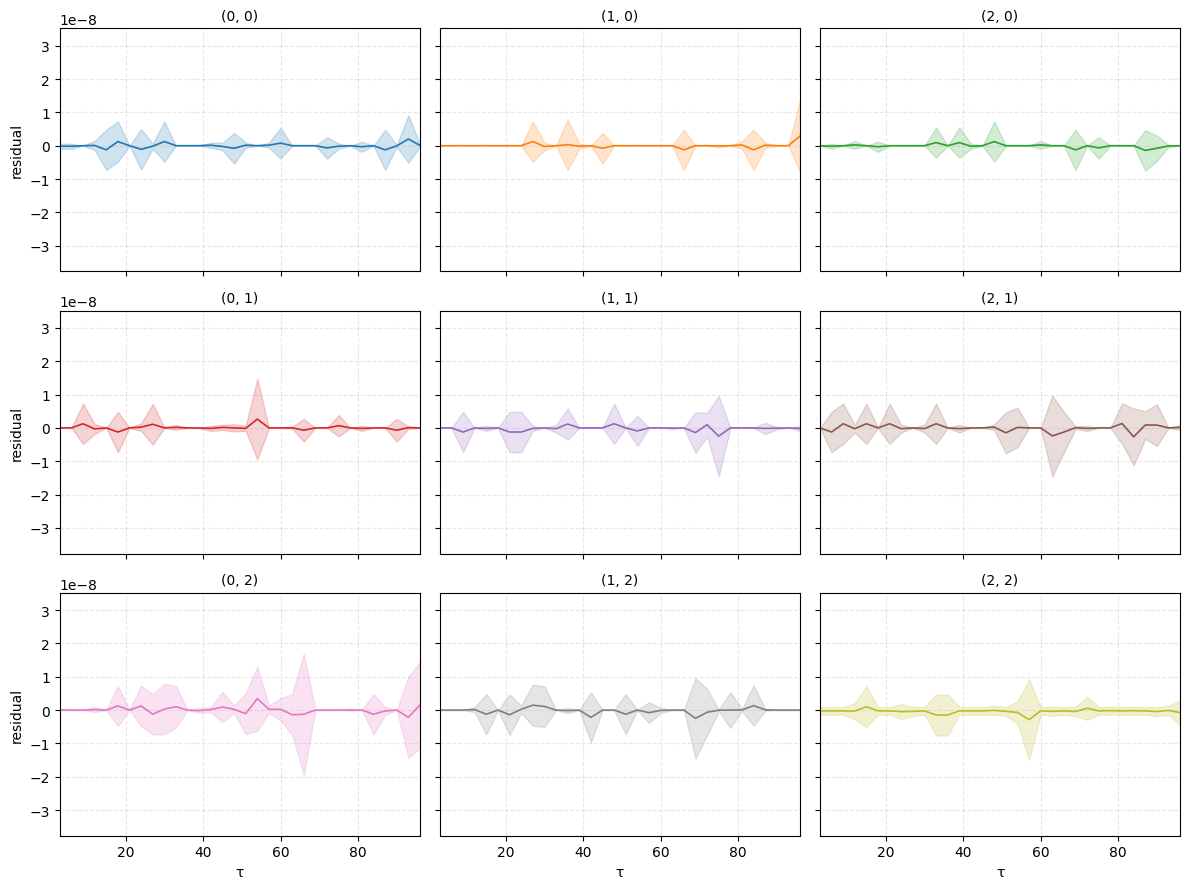

In [10]:
delta_flat_taus.shape # tau, n, B
matrix = np.mean(delta_flat_taus, axis =2)          
pair_labels = [f"{pixel}" for pixel in source_pixels]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math

# --- Assumes delta_flat_taus, tau_values, output_pairs are defined ---
# delta_flat_taus: shape (T_, P_, B)

# 1) Compute statistics
mean_taus = delta_flat_taus.mean(axis=2)  # (T_, P_)
std_taus  = delta_flat_taus.std(axis=2)   # (T_, P_)
T_, P_ = mean_taus.shape

# 2) Determine common axis limits
y_min = (mean_taus - std_taus).min()
y_max = (mean_taus + std_taus).max()
x_min, x_max = min(tau_values), max(tau_values)

# 3) Grid dimensions
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

# 4) Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), 
                         sharex=True, sharey=True)
axes = axes.flatten()

cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax = axes[j]
    color = cmap(j % cmap.N)
    mu  = mean_taus[:, j]
    sig = std_taus[:, j]/2

    ax.plot(tau_values, mu, 
            # marker='o',
            color=color, linewidth=1.2)
    ax.fill_between(tau_values, mu - sig, mu + sig, color=color, alpha=0.2)
    ax.set_title(pair_labels[j], fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(alpha=0.3, linestyle='--')

# Turn off any extra axes
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])

# Labels on edge plots
for ax in axes[:]:
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("residual", fontsize=10)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("τ", fontsize=10)

plt.tight_layout()
plt.show()


### Joint interaction plotting

In [28]:
all_Ipq_flat_taus.shape

(32, 9, 96)

In [6]:


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math

# --- Assumes delta_flat_taus, tau_values, output_pairs are defined ---
# delta_flat_taus: shape (T_, P_, B)

# 1) Compute statistics
mean_taus = all_Ipq_flat_taus.mean(axis=2)  # (T_, P_)
std_taus  = all_Ipq_flat_taus.std(axis=2)   # (T_, P_)
T_, P_ = mean_taus.shape

# 2) Determine common axis limits
y_min = (mean_taus - std_taus).min()
y_max = (mean_taus + std_taus).max()
x_min, x_max = min(tau_values), max(tau_values)

# 3) Grid dimensions
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

# 4) Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), 
                         sharex=True, sharey=True)
axes = axes.flatten()

cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax = axes[j]
    color = cmap(j % cmap.N)
    mu  = mean_taus[:, j]
    sig = std_taus[:, j]/2

    ax.plot(tau_values, mu, 
            # marker='o',
            color=color, linewidth=1.2)
    ax.fill_between(tau_values, mu - sig, mu + sig, color=color, alpha=0.2)
    ax.set_title('source cell: ' + pair_labels[j], fontsize=10)
    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(y_min, y_max)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_xlabel("τ", fontsize=10)

# Turn off any extra axes
# for k in range(P_, rows*cols):
#     fig.delaxes(axes[k])

# Labels on edge plots
for ax in axes[:]:
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("joint importance score", fontsize=10)
    # if ax.get_subplotspec().is_last_row():

plt.tight_layout()
plt.show()


NameError: name 'all_Ipq_flat_taus' is not defined

### Raw importance plotting 

In [15]:
# print(len(master_Ip.keys()))
print(all_Ip_flat_taus.shape)


(100, 3, 96)


TypeError: Invalid shape (10, 18, 32) for image data

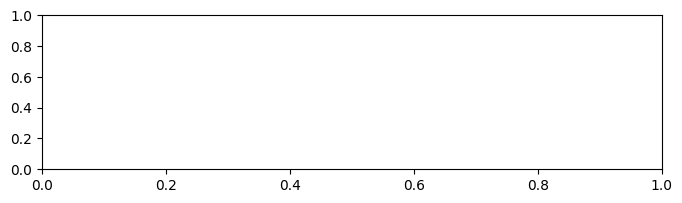

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute mean as before
# all_Ip_flat_taus.shape == (T=100, D=3, B)
mean_heat = np.nanmean(all_Ip_flat_taus, axis=2)  # shape (100, 3)

# 2) Transpose so that features (D=3) are on the y axis
heat_T = mean_heat.T  # now shape (3, 100)

# 3) Plot with a short height (3 strips)
plt.figure(figsize=(8, 2))               # wide and short
im = plt.imshow(
    heat_T,
    origin='lower',
    aspect='auto',
    cmap='viridis',
    interpolation='nearest'
)

# 4) Colorbar
cbar = plt.colorbar(im, fraction=0.04, pad=0.02)
cbar.set_label("Mean importance", fontsize=10)

# 5) Discrete ticks
# x-axis: time 0..99
plt.xticks(np.arange(0, mean_heat.shape[0], 10),  # every 10 for readability
           np.arange(0, mean_heat.shape[0], 10),
           fontsize=8)
# y-axis: features 0,1,2
plt.yticks([0,1,2], ["d=0","d=1","d=2"], fontsize=8)

plt.xlabel("Tau index (t)", fontsize=10)
plt.ylabel("Feature index (d)", fontsize=10)
plt.title("I(d,t) averaged over batch", fontsize=11)

plt.tight_layout()
plt.show()


### strategy: strips, blobs, patches : all calculation

#### Vertical strip

In [ ]:

print('source_pixels', source_pixels)
num_pairs = len(source_pixels)
out_dir = save_root / run_id / "interactions_strip"
pair_strategies =  ["vertical_strip"]#, "next_d"]
tau_values = list(range(3, 97, 3))






for strategy in pair_strategies:
    delta_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)
    all_Ip_flat_taus = np.zeros((len(tau_values), 2*num_pairs, B), dtype=float)
    all_Ipq_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)

    master_Ip = {} #defaultdict(list)

    for ti, tau in enumerate(tau_values):
        output_pairs = get_pair_strategy(source_pixels, T, D, tau, strategy=strategy)
        print(output_pairs)

        all_Ipq = compute_joint_importance(output_pairs, X_test, explainer)
        print('all_Ipq.keys():', all_Ipq.keys())

        # 2) build a list of *canonicalized* keys in the same order as output_pairs
        canonical_keys = []
        for p, q in output_pairs:
            src_key = _canon(p)   # ALWAYS a tuple of tuples
            tgt_key = _canon(q)
            canonical_keys.append((src_key, tgt_key))
        
        print('canonical_keys.keys():', canonical_keys)

        # 3) stack in that exact order
        all_Ipq_flat = np.stack([all_Ipq[key] for key in canonical_keys], axis=0)
        
        # 4) assign into the big tensor
        all_Ipq_flat_taus[ti, :, :, :] = all_Ipq_flat



# np.save(out_dir / f"delta_flat_taus.npy", delta_flat_taus)
# np.save(out_dir / f"all_Ip_flat_taus.npy", all_Ip_flat_taus)
np.save(out_dir / f"all_Ipq_flat_taus.npy", all_Ipq_flat_taus)







source_pixels [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
[((0, 0), [(3, 0), (3, 1), (3, 2)]), ((1, 0), [(4, 0), (4, 1), (4, 2)]), ((2, 0), [(5, 0), (5, 1), (5, 2)]), ((0, 1), [(3, 0), (3, 1), (3, 2)]), ((1, 1), [(4, 0), (4, 1), (4, 2)]), ((2, 1), [(5, 0), (5, 1), (5, 2)]), ((0, 2), [(3, 0), (3, 1), (3, 2)]), ((1, 2), [(4, 0), (4, 1), (4, 2)]), ((2, 2), [(5, 0), (5, 1), (5, 2)])]


/home/anaconda3/envs/winit/lib/python3.9/site-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)


all_Ipq.keys(): dict_keys([(((0, 0),), ((3, 0), (3, 1), (3, 2))), (((1, 0),), ((4, 0), (4, 1), (4, 2))), (((2, 0),), ((5, 0), (5, 1), (5, 2))), (((0, 1),), ((3, 0), (3, 1), (3, 2))), (((1, 1),), ((4, 0), (4, 1), (4, 2))), (((2, 1),), ((5, 0), (5, 1), (5, 2))), (((0, 2),), ((3, 0), (3, 1), (3, 2))), (((1, 2),), ((4, 0), (4, 1), (4, 2))), (((2, 2),), ((5, 0), (5, 1), (5, 2)))])
canonical_keys.keys(): [(((0, 0),), ((3, 0), (3, 1), (3, 2))), (((1, 0),), ((4, 0), (4, 1), (4, 2))), (((2, 0),), ((5, 0), (5, 1), (5, 2))), (((0, 1),), ((3, 0), (3, 1), (3, 2))), (((1, 1),), ((4, 0), (4, 1), (4, 2))), (((2, 1),), ((5, 0), (5, 1), (5, 2))), (((0, 2),), ((3, 0), (3, 1), (3, 2))), (((1, 2),), ((4, 0), (4, 1), (4, 2))), (((2, 2),), ((5, 0), (5, 1), (5, 2)))]
[((0, 0), [(6, 0), (6, 1), (6, 2)]), ((1, 0), [(7, 0), (7, 1), (7, 2)]), ((2, 0), [(8, 0), (8, 1), (8, 2)]), ((0, 1), [(6, 0), (6, 1), (6, 2)]), ((1, 1), [(7, 0), (7, 1), (7, 2)]), ((2, 1), [(8, 0), (8, 1), (8, 2)]), ((0, 2), [(6, 0), (6, 1), (6,

In [12]:
all_Ipq_flat_taus.shape

(32, 9, 96, 10)

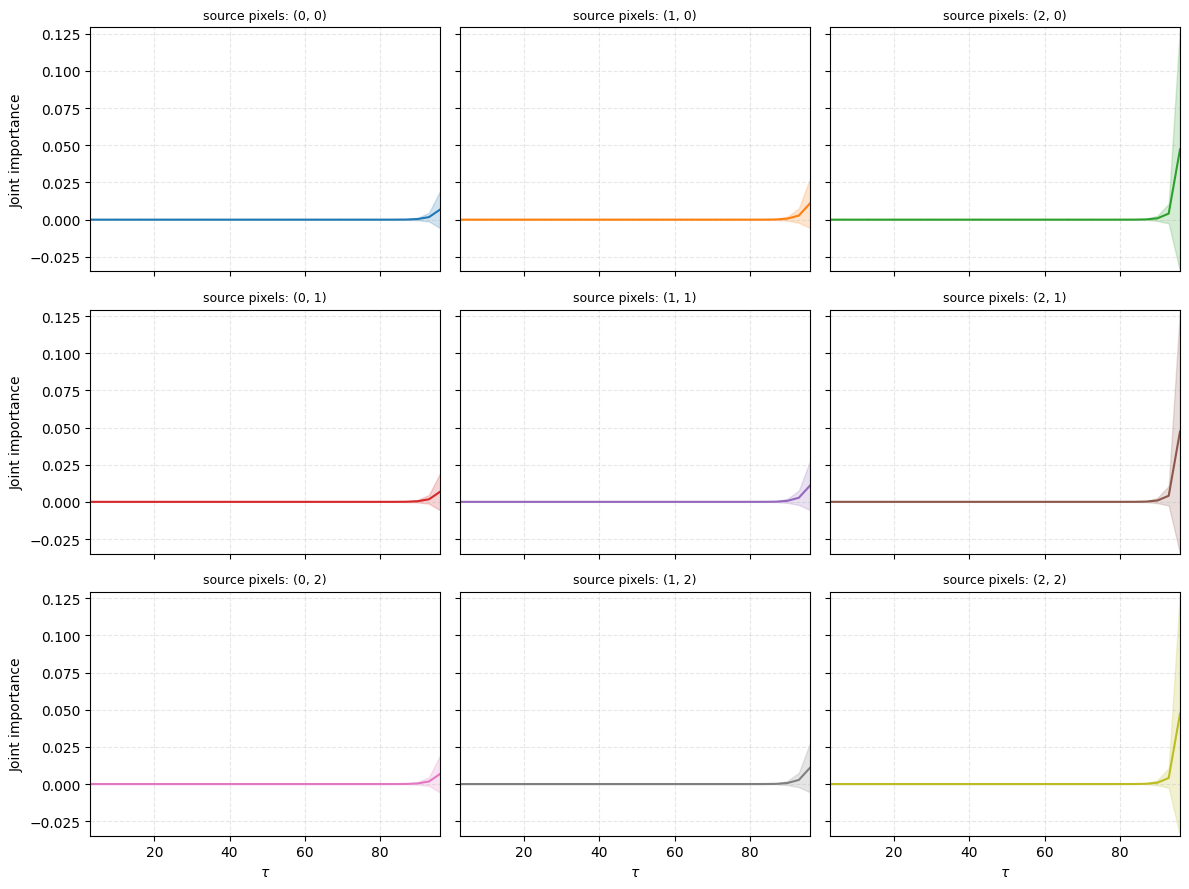

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: shape (T_, P_, B)
# source_pixels:      list of P_ pixel coords
# tau_values:         list of T_ τ values

# 1) Compute mean & std over the batch axis
mean_Ipq = all_Ipq_flat_taus.mean(axis=2)  # (T_, P_)
std_Ipq  = all_Ipq_flat_taus.std(axis=2)   # (T_, P_)
T_, P_   = mean_Ipq.shape

# 2) Grid dimensions
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

# 3) Set up figure & colormap
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                         sharex=True, sharey=True)
axes = axes.flatten()
cmap = cm.get_cmap('tab10')

# 4) Global y-limits for consistency
ymin = (mean_Ipq - std_Ipq).min()
ymax = (mean_Ipq + std_Ipq).max()

# 5) Plot each pixel’s curve + band
for j in range(P_):
    ax = axes[j]
    color = cmap(j % cmap.N)
    mu  = mean_Ipq[:, j]
    sig = std_Ipq[:, j]

    ax.plot(tau_values, mu,
            linewidth=1.5,
            color=color, label=f"{source_pixels[j]}")
    ax.fill_between(tau_values,
                    mu - sig,
                    mu + sig,
                    color=color, alpha=0.2)

    ax.set_title(f"source pixels: {source_pixels[j]}", fontsize=9)
    ax.set_xlim(min(tau_values), max(tau_values))
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3, linestyle='--')

    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel(r"$\tau$", fontsize=10)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Joint importance", fontsize=10)

# 6) Remove unused axes
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])

# 7) Legend (optional, or drop if too crowded)
# fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0))

plt.tight_layout()
plt.show()


## Windowed imp score calculations

### strategy: strips, blobs, patches : all calculation

In [ ]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print('source_pixels', source_pixels)
num_pairs = len(source_pixels)
out_dir = save_root / run_id / "interactions_window_strip"
pair_strategies =  ["vertical_strip"]#, "next_d"]
tau_values = list(range(3, 19, 3))






for strategy in pair_strategies:
    delta_flat_taus = np.zeros((len(tau_values), num_pairs, B, explainer.window_size), dtype=float)
    # all_Ip_flat_taus = np.zeros((len(tau_values), 2*num_pairs, B, ), dtype=float)
    all_Ipq_flat_taus = np.zeros((len(tau_values), num_pairs, B, explainer.window_size), dtype=float)
    
    all_pixels = []
    master_Ip = {} #defaultdict(list)
  
    for ti, tau in enumerate(tau_values):
        output_pairs = get_pair_strategy(source_pixels, T, D, tau, strategy=strategy)
        print(output_pairs)

        # 1) Prepping Single pixel importance
        all_pixels = all_pixels + list(set({pix for src, tgts in output_pairs for pix in ((src,) + tuple(tgts))}))
        all_pixels = list(set(all_pixels))
        print('all_pixels:', all_pixels)
        print(len(all_pixels))

        

        
        # 2) Joint blob-blob importance
        all_Ipq = compute_joint_importance(output_pairs, X_test, explainer)
        print('all_Ipq.keys():', all_Ipq.keys())

        # 2.1) build a list of *canonicalized* keys in the same order as output_pairs
        canonical_keys = []
        for p, q in output_pairs:
            src_key = _canon(p)   # ALWAYS a tuple of tuples
            tgt_key = _canon(q)
            canonical_keys.append((src_key, tgt_key))
        
        print('canonical_keys.keys():', canonical_keys)

        # 2.2) stack in that exact order
        all_Ipq_flat = np.stack([all_Ipq[key] for key in canonical_keys], axis=0)
        
        # 2.3) assign into the big tensor
        all_Ipq_flat_taus[ti, :, :, :] = all_Ipq_flat

    del all_Ipq, all_Ipq_flat, canonical_keys   # anything you no longer need
    # 1.2 Calculate single importance
    all_Ip = single_importance(explainer, X_test, all_pixels)
    print(len(all_Ip))
    # for pix, scores in all_Ip.items():
    #     # scores is a 1D array of shape (B,)
    #     master_Ip[pix] = scores

    all_Ip_flat_taus = np.zeros((T, D, B, explainer.window_size), 0, dtype=float)
    for (t, d), scores in  all_Ip.items():
        # scores must be shape (B,W)
        print('opening the all_Ip now, scores.shape:', scores.shape)
        print('(t,d) in all_Ip.keys():', t, d)
        all_Ip_flat_taus[t, d, :, :] = scores

# np.save(out_dir / f"delta_flat_taus.npy", delta_flat_taus)
np.save(out_dir / f"all_Ip_flat_taus.npy", all_Ip_flat_taus)
np.save(out_dir / f"all_Ipq_flat_taus.npy", all_Ipq_flat_taus)







source_pixels [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
[((0, 0), [(3, 0), (3, 1), (3, 2)]), ((1, 0), [(4, 0), (4, 1), (4, 2)]), ((2, 0), [(5, 0), (5, 1), (5, 2)]), ((0, 1), [(3, 0), (3, 1), (3, 2)]), ((1, 1), [(4, 0), (4, 1), (4, 2)]), ((2, 1), [(5, 0), (5, 1), (5, 2)]), ((0, 2), [(3, 0), (3, 1), (3, 2)]), ((1, 2), [(4, 0), (4, 1), (4, 2)]), ((2, 2), [(5, 0), (5, 1), (5, 2)])]
all_pixels: [(0, 1), (1, 2), (4, 0), (2, 1), (0, 0), (3, 1), (1, 1), (2, 0), (5, 1), (4, 2), (3, 0), (0, 2), (5, 0), (2, 2), (1, 0), (3, 2), (4, 1), (5, 2)]
18
all_Ipq.keys(): dict_keys([(((0, 0),), ((3, 0), (3, 1), (3, 2))), (((1, 0),), ((4, 0), (4, 1), (4, 2))), (((2, 0),), ((5, 0), (5, 1), (5, 2))), (((0, 1),), ((3, 0), (3, 1), (3, 2))), (((1, 1),), ((4, 0), (4, 1), (4, 2))), (((2, 1),), ((5, 0), (5, 1), (5, 2))), (((0, 2),), ((3, 0), (3, 1), (3, 2))), (((1, 2),), ((4, 0), (4, 1), (4, 2))), (((2, 2),), ((5, 0), (5, 1), (5, 2)))])
canonical_keys.keys(): [(((0, 0),), ((3, 0), (3, 

In [22]:
all_Ipq_flat_taus = np.load(out_dir / f"all_Ipq_flat_taus.npy")

#### Joint interaction plotting

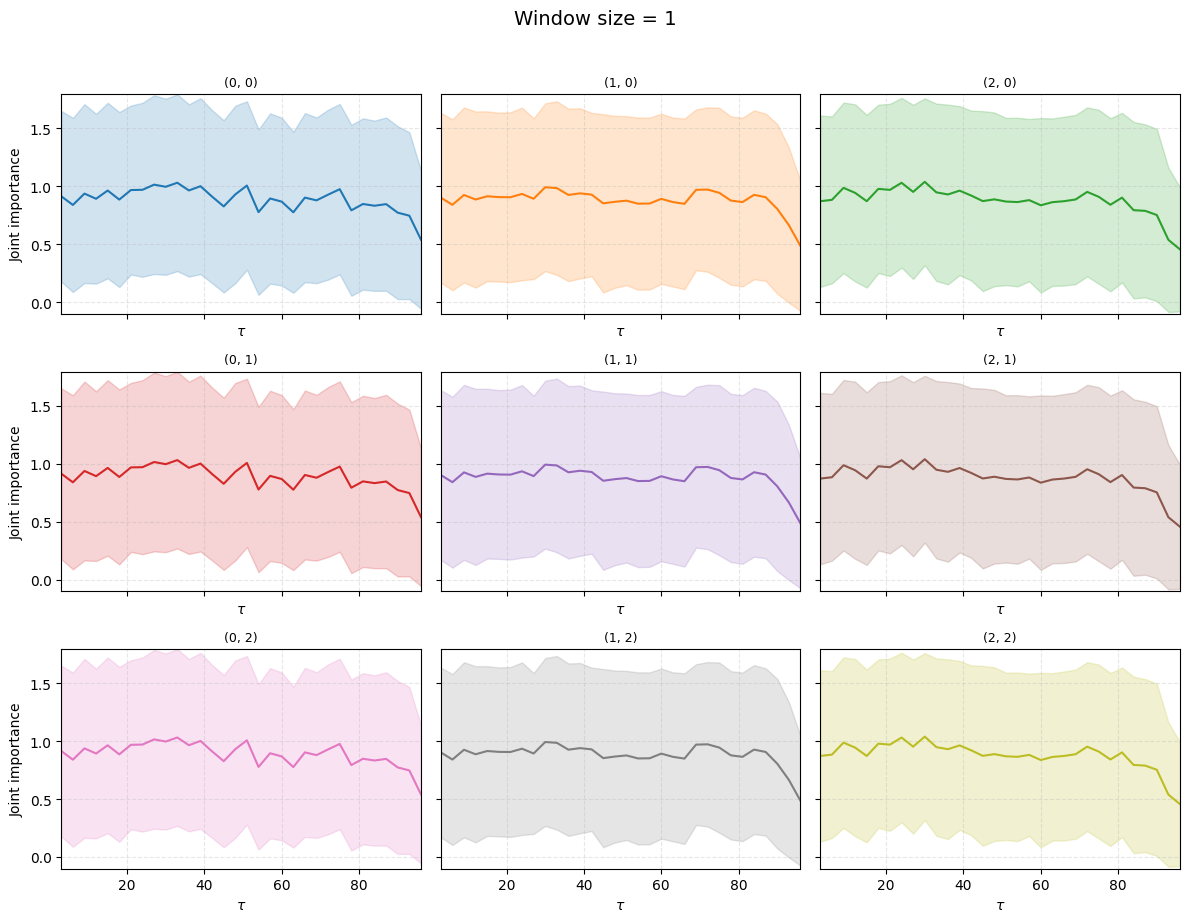

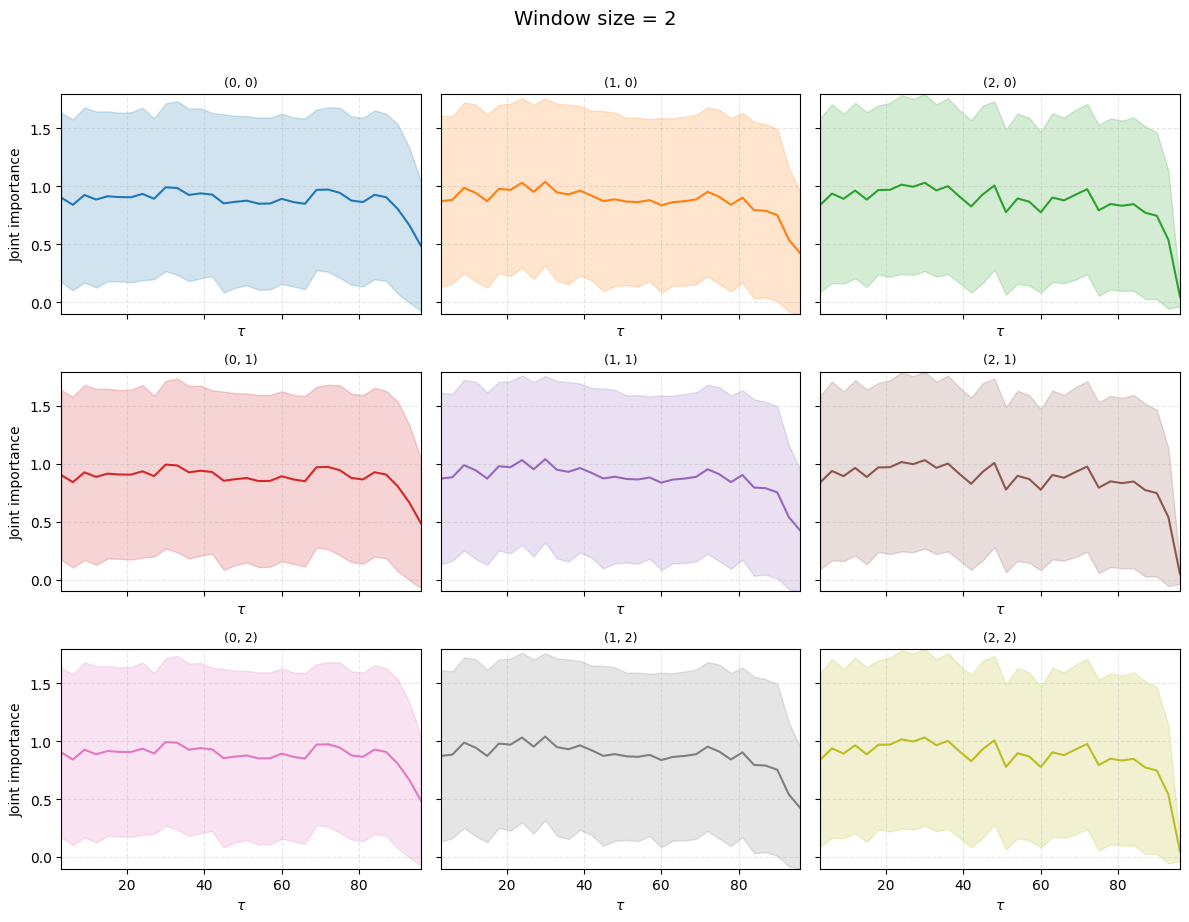

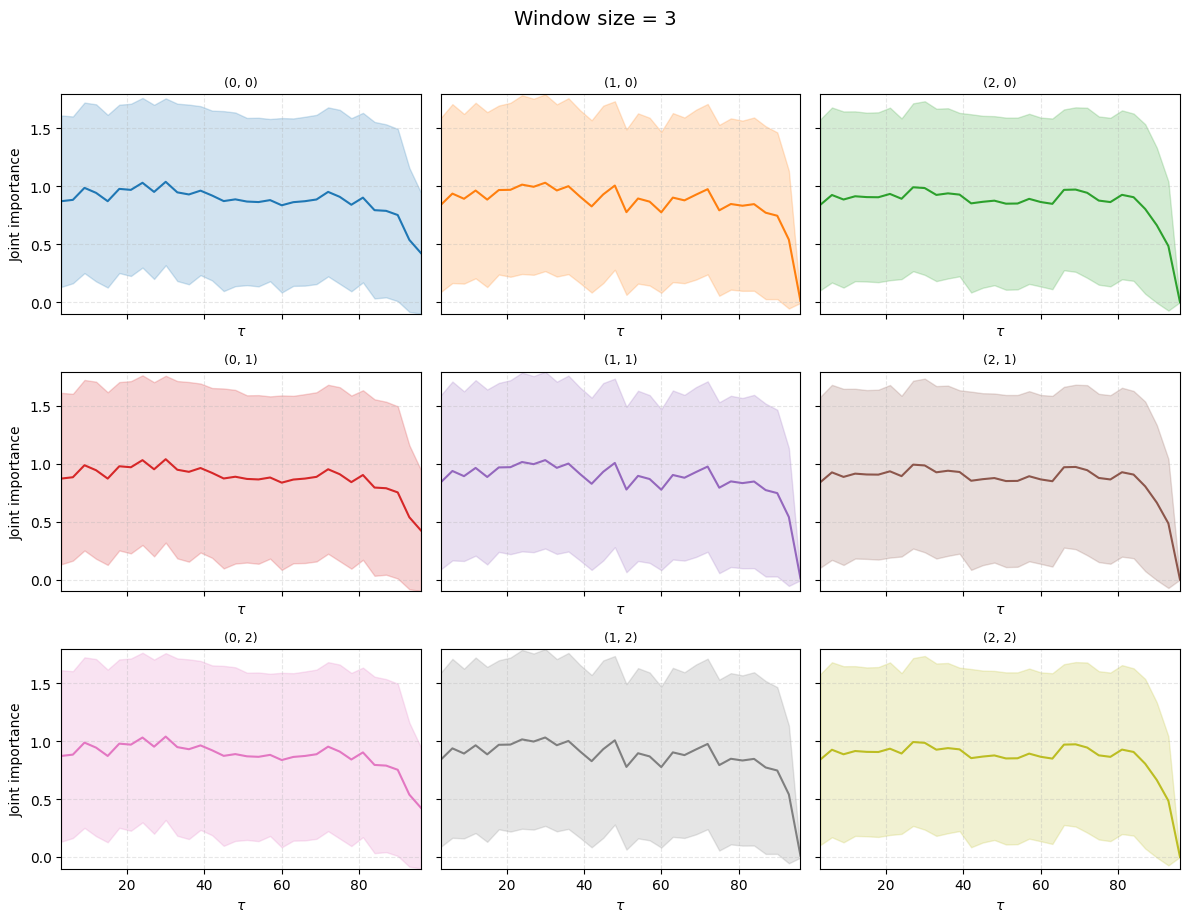

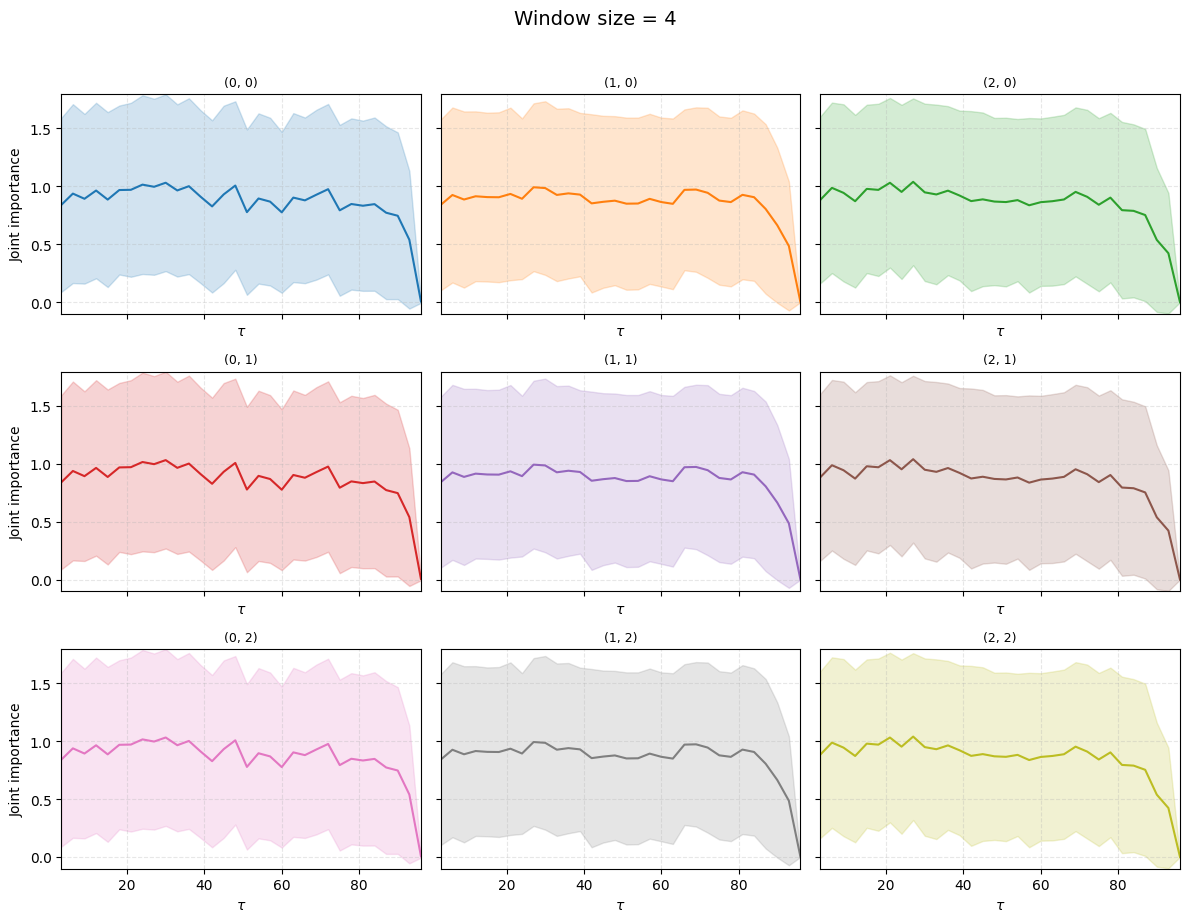

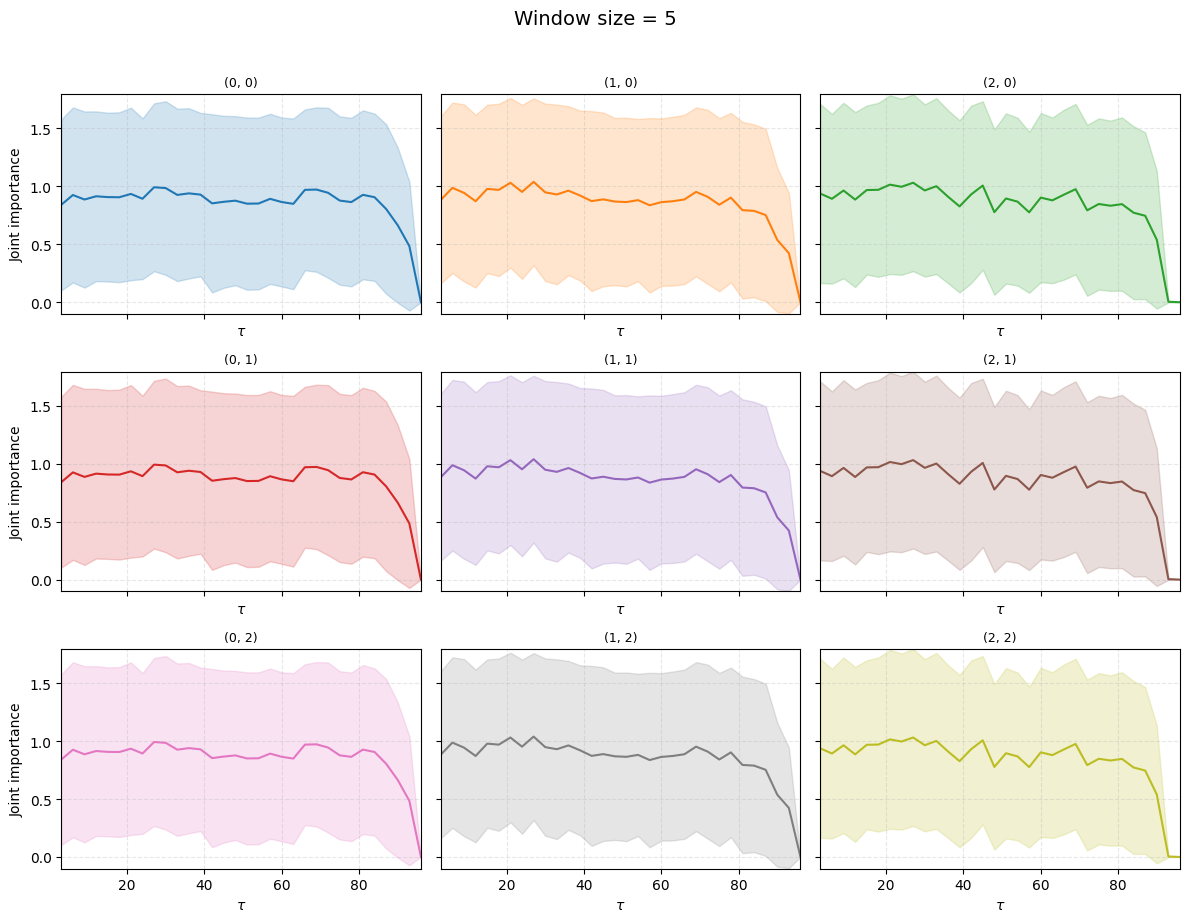

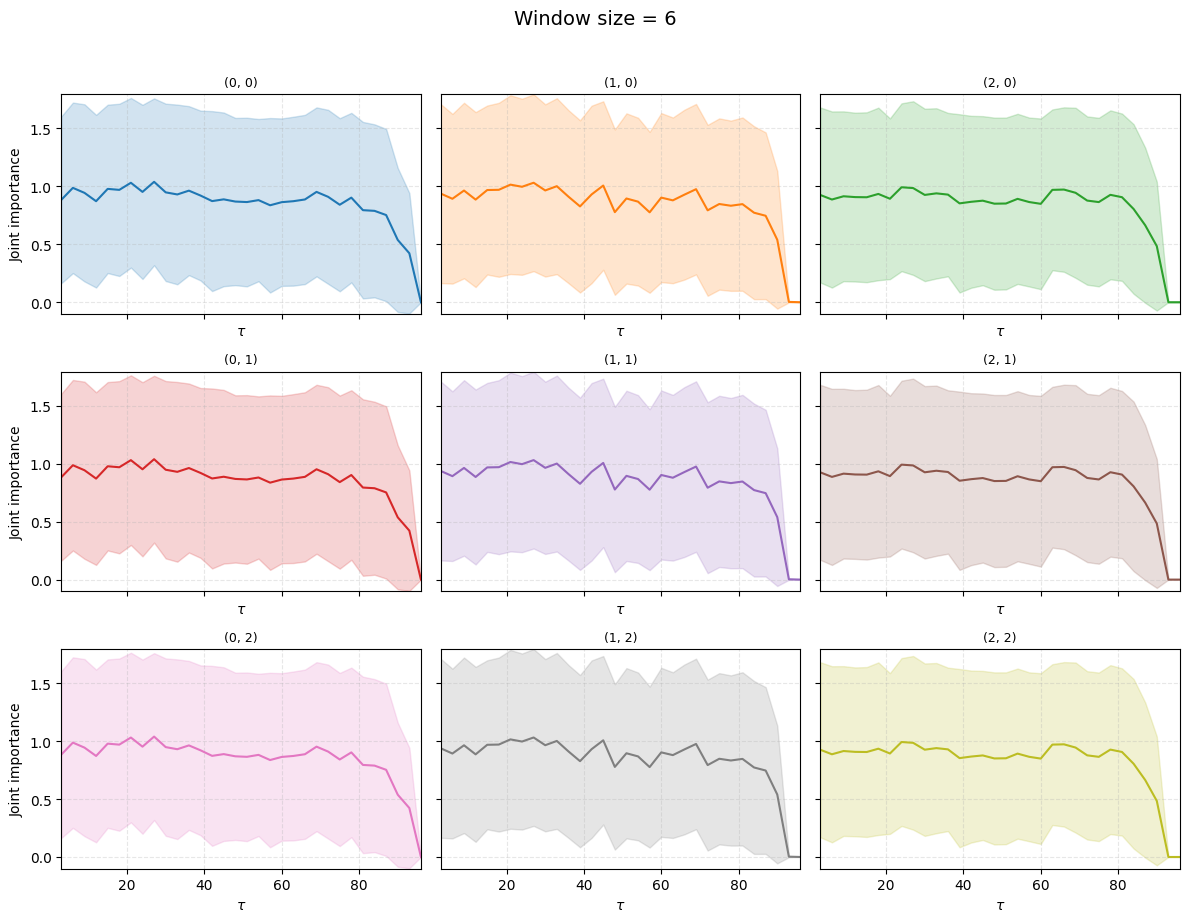

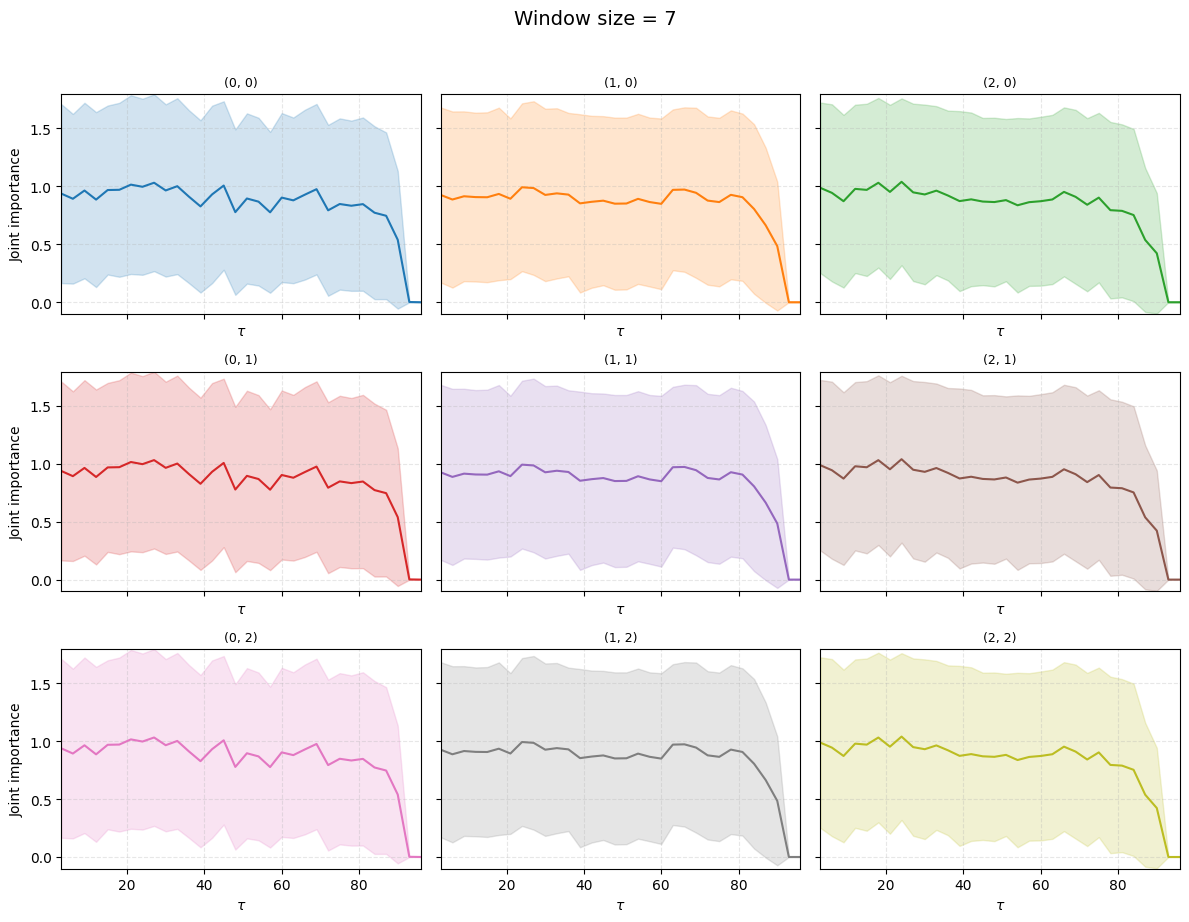

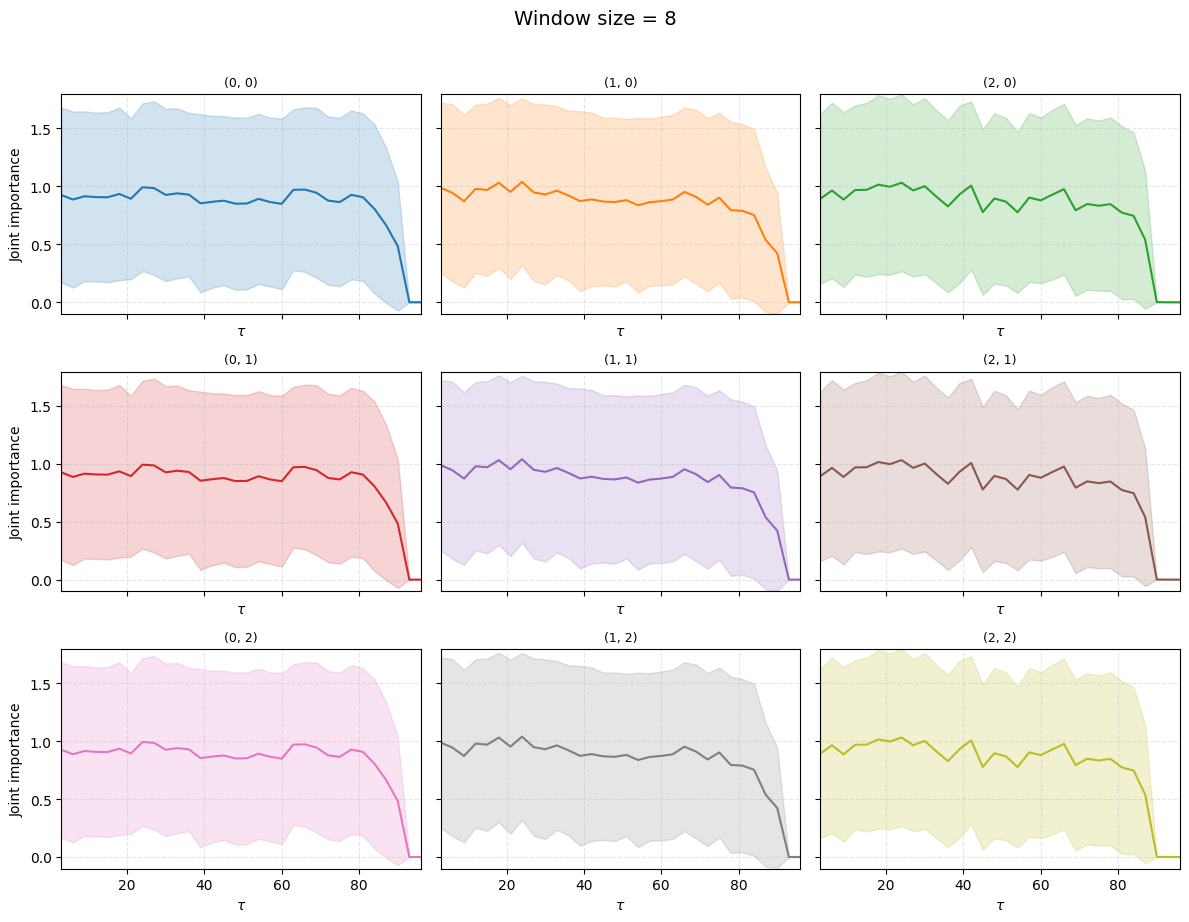

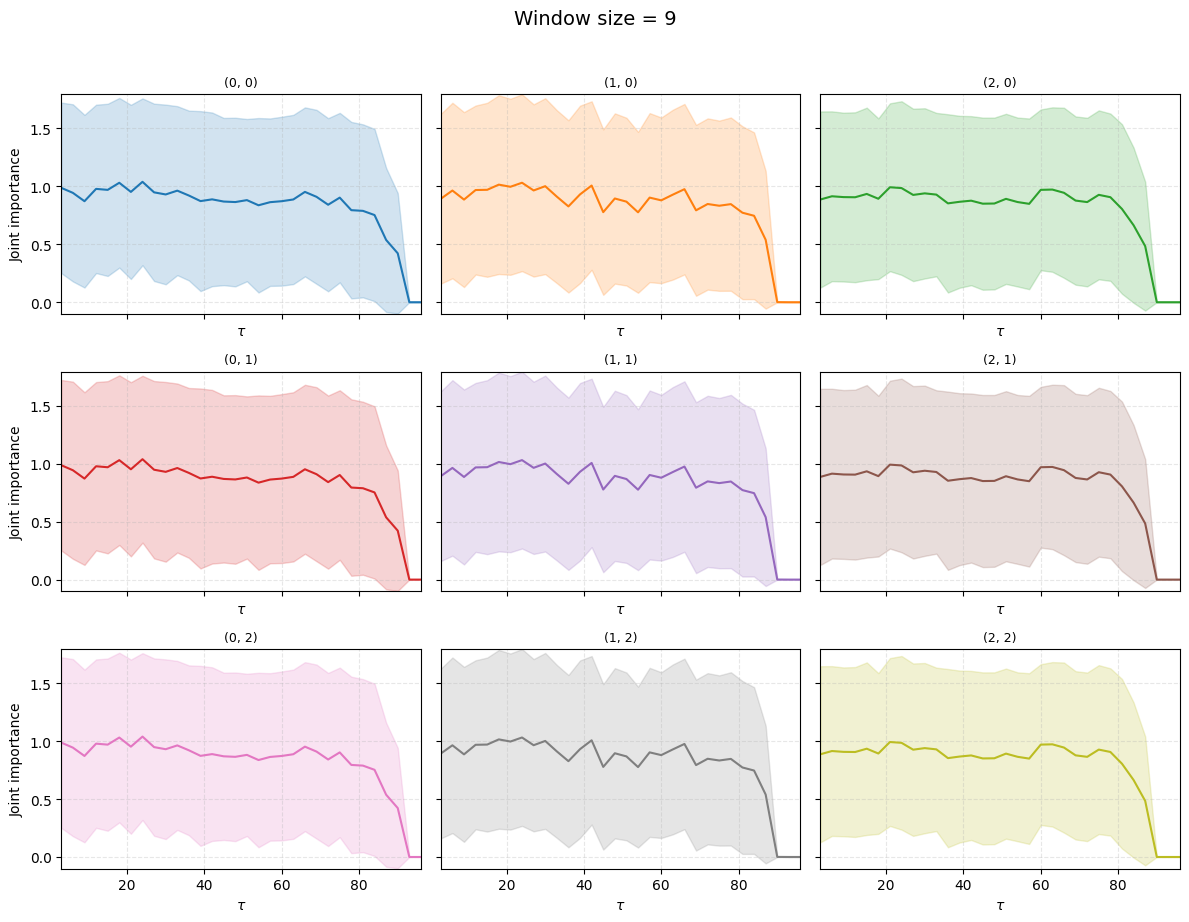

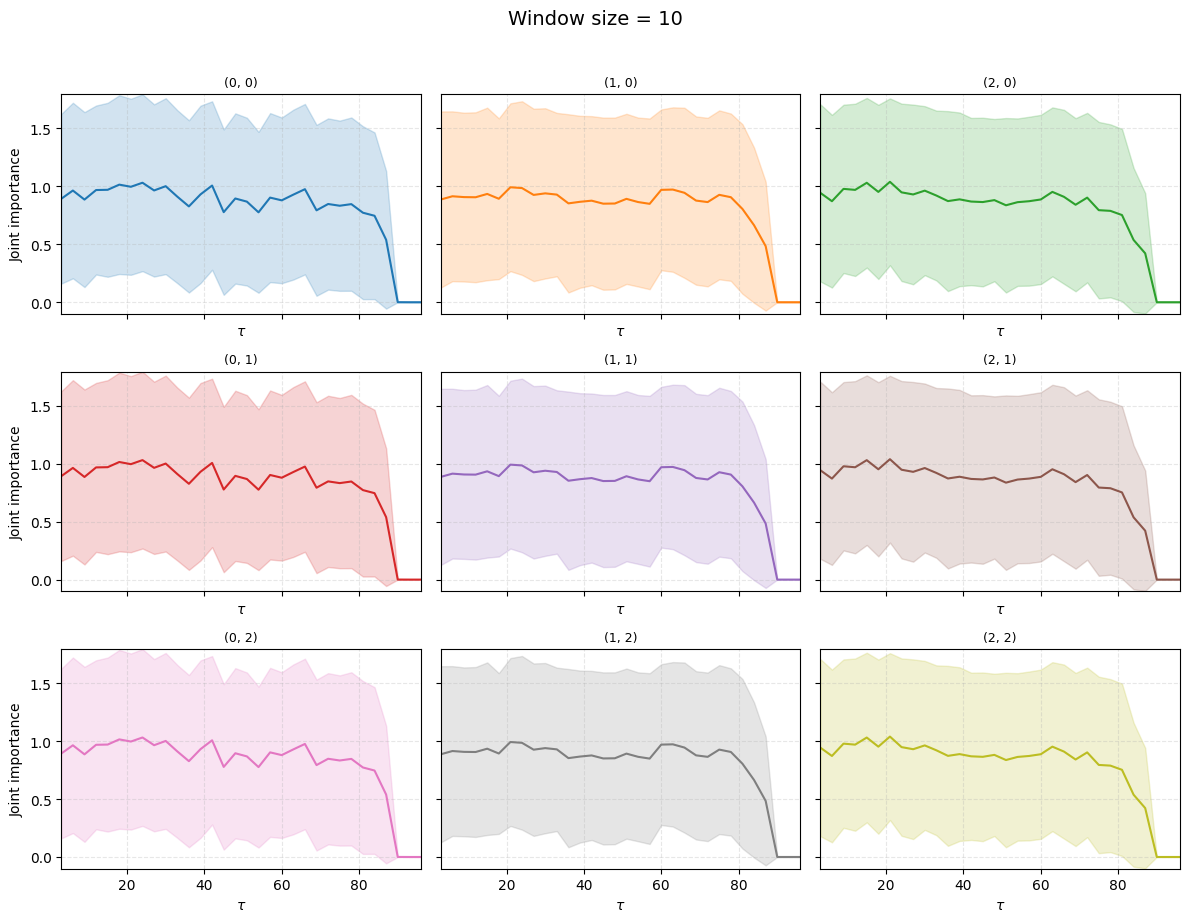

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: (T_, P_, B, W)
T_, P_, B, W = all_Ipq_flat_taus.shape
tau_vals = tau_values            # alias
src_pix  = source_pixels         # length P_

# mean & std over batch
mu  = all_Ipq_flat_taus.mean(axis=2)   # (T_, P_, W)
sig = all_Ipq_flat_taus.std(axis=2)    # (T_, P_, W)

# global y-lims across ALL windows (so plots are comparable)
ymin = (mu - sig).min()
ymax = (mu + sig).max()

# grid size for subplots
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))
cmap = cm.get_cmap('tab10')

def plot_window(w_idx):
    """One full grid for the w-th window."""
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                             sharex=True, sharey=True)
    axes = axes.ravel()

    for j in range(P_):
        ax   = axes[j]
        col  = cmap(j % cmap.N)
        m_j  = mu[:, j, w_idx]
        s_j  = sig[:, j, w_idx]

        ax.plot(tau_vals, m_j, color=col, linewidth=1.5)
        ax.fill_between(tau_vals, m_j - s_j, m_j + s_j,
                        color=col, alpha=0.2)

        ax.set_title(f"{src_pix[j]}", fontsize=9)
        ax.set_xlim(min(tau_vals), max(tau_vals))
        ax.set_ylim(ymin, ymax)
        ax.grid(alpha=0.3, linestyle='--')

        # if ax.get_subplotspec().is_last_row():
        ax.set_xlabel(r"$\tau$", fontsize=10)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Joint importance", fontsize=10)

    # remove unused axes
    # for k in range(P_, rows*cols):
    #     fig.delaxes(axes[k])

    fig.suptitle(f"Window size = {w_idx+1}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    # Or save: fig.savefig(f"joint_imp_w{w_idx}.png", dpi=300, bbox_inches='tight')

# ---- repeat for all W ----
for w in range(W):
    plot_window(w)


#### Joint importance: agg over W

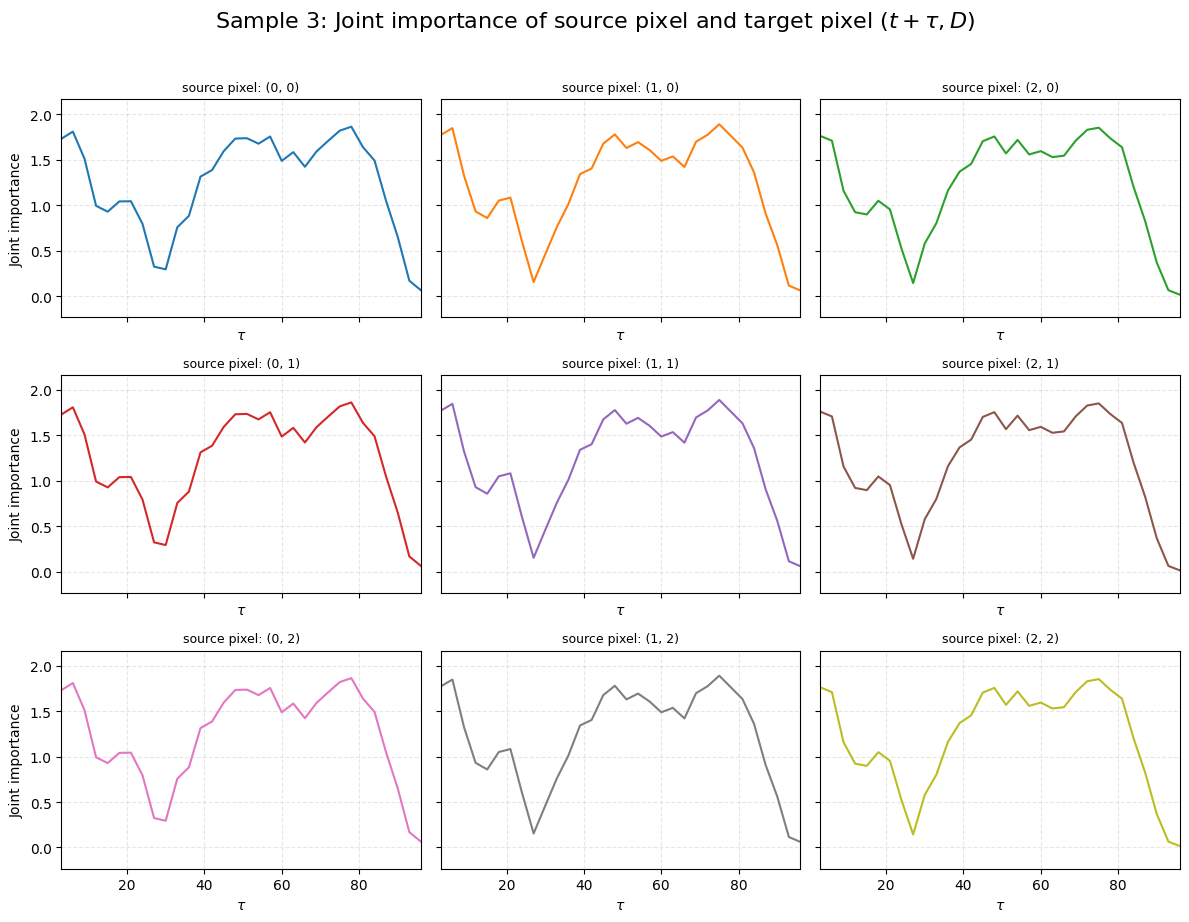

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: (T_, P_, B, W)
T_, P_, B, W = all_Ipq_flat_taus.shape
tau_vals = tau_values
src_pix  = source_pixels

sample_idx = 2

mu  = all_Ipq_flat_taus[:,:,sample_idx,:].mean(axis=2)   # (T_, P_)
# sig = all_Ipq_flat_taus[:,:,sample_idx,:].std(axis=2)    # (T_, P_)


# mu  = all_Ipq_flat_taus.mean(axis=(2, 3))   # (T_, P_)
# sig = all_Ipq_flat_taus.std(axis=(2, 3))    # (T_, P_)

# 2) global y-lims
ymin = (mu - sig).min()
ymax = (mu + sig).max()

# 3) subplot grid
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                         sharex=True, sharey=True)
axes = axes.ravel()
cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax   = axes[j]
    color = cmap(j % cmap.N)
    m_j  = mu[:, j]
    s_j  = sig[:, j]

    ax.plot(tau_vals, m_j, color=color, linewidth=1.5)
    # ax.fill_between(tau_vals, m_j - s_j, m_j + s_j, color=color, alpha=0.2)

    ax.set_title(f"source pixel: {src_pix[j]}", fontsize=9)
    ax.set_xlim(min(tau_vals), max(tau_vals))
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3, linestyle='--')

    # if ax.get_subplotspec().is_last_row():
    ax.set_xlabel(r"$\tau$", fontsize=10)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Joint importance", fontsize=10)

# remove extras
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])
fig.suptitle(fr"Sample {sample_idx+1}: Joint importance of source pixel and target pixel $(t+\tau, D)$",
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### Joint importance: aggregate over W and B

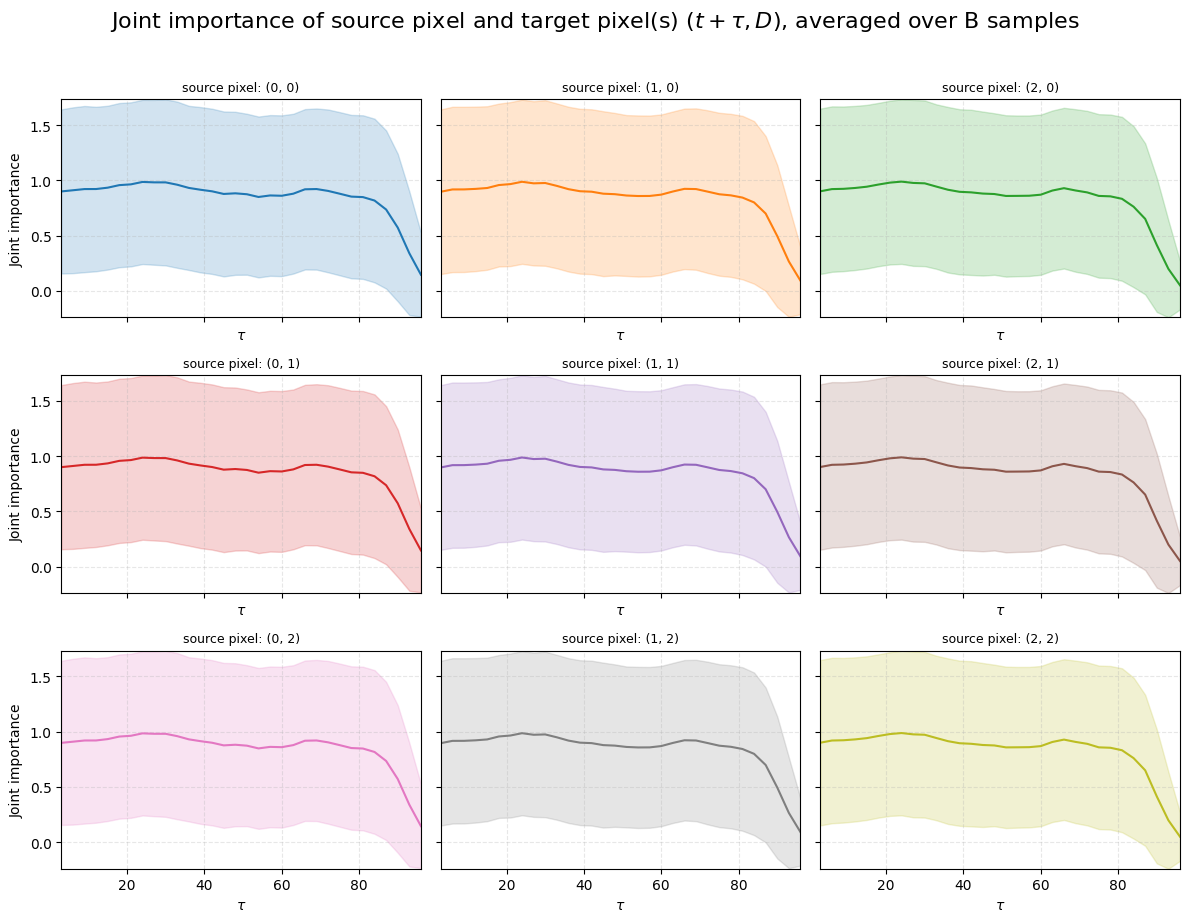

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: (T_, P_, B, W)
T_, P_, B, W = all_Ipq_flat_taus.shape
tau_vals = tau_values
src_pix  = source_pixels


mu  = all_Ipq_flat_taus.mean(axis=(2, 3))   # (T_, P_)
sig = all_Ipq_flat_taus.std(axis=(2, 3))    # (T_, P_)

# 2) global y-lims
ymin = (mu - sig).min()
ymax = (mu + sig).max()

# 3) subplot grid
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                         sharex=True, sharey=True)
axes = axes.ravel()
cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax   = axes[j]
    color = cmap(j % cmap.N)
    m_j  = mu[:, j]
    s_j  = sig[:, j]

    ax.plot(tau_vals, m_j, color=color, linewidth=1.5)
    ax.fill_between(tau_vals, m_j - s_j, m_j + s_j, color=color, alpha=0.2)

    ax.set_title(f"source pixel: {src_pix[j]}", fontsize=9)
    ax.set_xlim(min(tau_vals), max(tau_vals))
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3, linestyle='--')

    # if ax.get_subplotspec().is_last_row():
    ax.set_xlabel(r"$\tau$", fontsize=10)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Joint importance", fontsize=10)

# remove extras
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])
fig.suptitle(fr"Joint importance of source pixel and target pixel(s) $(t+\tau, D)$, averaged over B samples",
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Raw importance from old attribution method

In [13]:
# 1) Prepare your explainer and data
explainer = BiWinITExplainer(
                    device,
                    dataset.feature_size,
                    dataset.get_name(),
                    path= ckpt_path / dataset.get_name() / str(cv),
                    train_loader=dataset.train_loaders[cv],  # for CF generaton if required, NOT for training 
                    other_args = xplainer_params
                )   

explainer.set_model(model,
                    set_eval=True)

B, D, T = X_test.shape

imp_score_old = explainer.attribute(X_test, all_zero_cf= True)
imp_score_old.shape # B, D, T, W

TypeError: attribute() got an unexpected keyword argument 'all_zero_cf'

In [16]:

heat = imp_score_old[0,:,:,:]
heat

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  8.33034515e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -7.18140602e-03,  1.84007883e-02],
        ...,
        [ 6.71029091e-04,  1.45912170e-04,  7.40766525e-04, ...,
         -1.63650513e-03, -3.96716595e-03,  8.42356682e-03],
        [-4.98294830e-05, -2.26825476e-04,  1.87367201e-04, ...,
         -3.66526842e-03,  3.13475728e-03,  3.44585329e-02],
        [ 4.14609909e-04, -3.00049782e-04,  1.07574463e-03, ...,
         -4.42743301e-04, -1.89930201e-02,  7.49167204e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

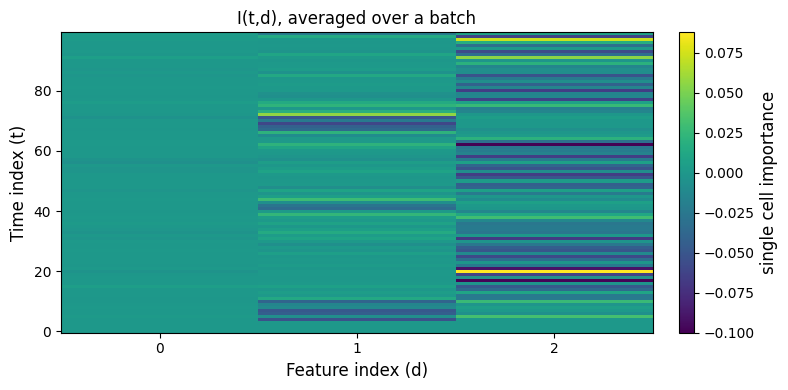

In [17]:


import numpy as np
import matplotlib.pyplot as plt


heat = imp_score_old[0,:,:,:]

# mean_heat = np.mean(imp_score_old, axis=0)  # shape [D, T, W]
window_size = 6
heat = heat[:,:,window_size].T

# 2) Plot
plt.figure(figsize=(8, 4))
im = plt.imshow(heat, origin='lower', aspect='auto', cmap='viridis')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("single cell importance", fontsize=12)


plt.xticks(np.arange(D), np.arange(D), fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Feature index (d)", fontsize=12)
plt.ylabel("Time index (t)", fontsize=12)
plt.title("I(t,d), averaged over a batch", fontsize=12)

plt.tight_layout()
plt.show()


## Old code

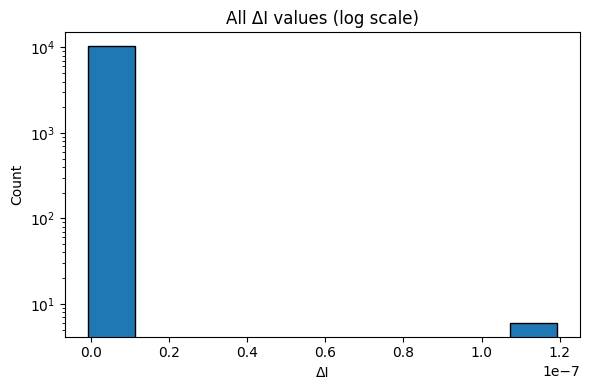

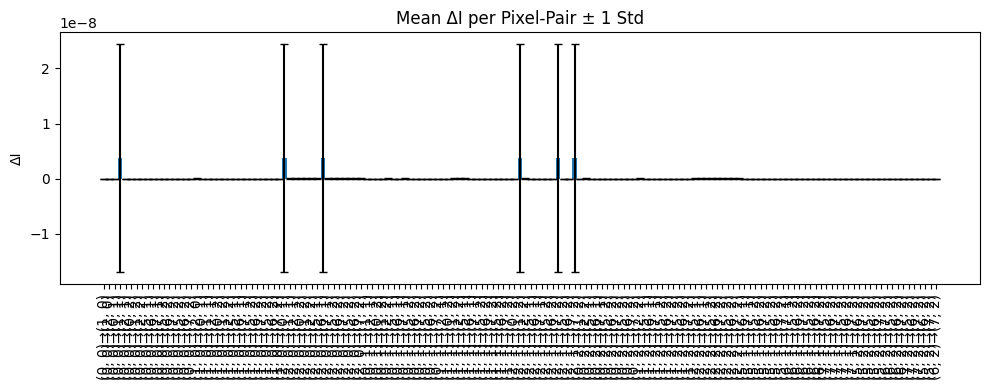

ValueError: The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of ticklabels (9).

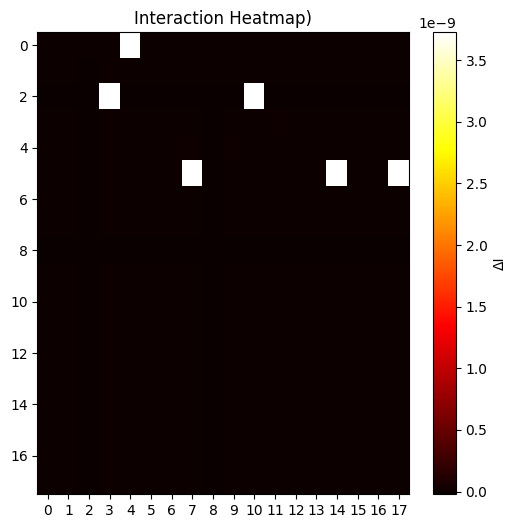

In [ ]:
# For illustration, unpack shapes:


# 1) compute mean & std over the B axis
delta_mean_batch = delta.mean(axis=2)  # shape (n, n)
delta_std_batch  = delta.std(axis=2)   # shape (n, n)

# 2) build pair labels and flattened arrays of means/stds
pair_labels = []
mean_vals   = []
std_vals    = []
for i in range(n):
    for j in range(i+1, n):
        pair_labels.append(f"{all_pixels[i]}→{all_pixels[j]}")
        mean_vals.append(delta_mean_batch[i, j])
        std_vals.append(delta_std_batch[i, j])
mean_vals = np.array(mean_vals)
std_vals  = np.array(std_vals)



# 5) plot skewed histogram (log scale)
plt.figure(figsize=(6, 4))
plt.hist(delta.flatten(), bins=10, edgecolor='k', log=True)
plt.title("All ΔI values (log scale)")
plt.xlabel("ΔI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6) bar chart of mean ΔI ± std
plt.figure(figsize=(10, 4))
plt.bar(range(len(mean_vals)), mean_vals, yerr=std_vals, capsize=3)
plt.xticks(range(len(mean_vals)), pair_labels, rotation=90)
plt.title("Mean ΔI per Pixel-Pair ± 1 Std")
plt.ylabel("ΔI")
plt.tight_layout()
plt.show()

# 7) heatmap of the mean
heat = np.mean(delta, axis = 2)
plt.figure(figsize=(6, 6))
im = plt.imshow(heat, cmap='hot', aspect='auto')
plt.colorbar(im, label='ΔI')
plt.title(f"Interaction Heatmap)")
plt.xticks(np.arange(n), [str(p) for p in all_pixels], rotation=90)
plt.yticks(np.arange(n), [str(p) for p in all_pixels])
plt.tight_layout()
plt.show()


        
        # print(len(tau_values), len(values))
        # print(values)
        # plt.plot(tau_values, values, marker='o', label=strategy)

    
    # plt.title(f"Mean ΔI vs τ ({strategy})")
    # plt.xlabel("τ")
    # plt.ylabel("Mean ΔI")
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

# 9) illustrate an example pair
# example_pair = pair_sampling_strategy(pixels, T, D, tau=1, strategy="same_d")[0]
# illustrate_pair(example_pair, T, D)


In [ ]:
delta.shape